# A Learned Representation For Artistic Style
steal idea from 
* https://github.com/pytorch/examples/tree/master/fast_neural_style
* https://github.com/kewellcjj/pytorch-multiple-style-transfer
* https://github.com/Aftaab99/pytorch-multiple-style-transfer<br>
the initialization of instance norm's affine

In [ ]:
# !pip install dotmap
# !pip install torch
# !pip install torchvision

In [1]:
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import utils
from transformer_net import TransformerNet
from vgg import VGG

import glob
from collections import defaultdict

import matplotlib.pyplot as plt

from IPython import display

In [2]:
from dotmap import DotMap
class default_config:
  seed=228922
  batch_size=16
  big_size=512
  image_size=256
  style_size=None
  dataset="val2017"
  lr = 1e-3
  epochs = 100
  
  save_every_n_batches=300
  
  weight_decay = 0.01
  content_weight = 1e5
  content_weight_decay = 0.999
  content_weight_lower = 1e5
  
  style_weight = 1e10
  
  
  style_path_template="style/*.jpg"
  style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
  content_layers = ["relu2_2"]
  
  feature_layers = list(set(style_layers+content_layers))
  
  n_style=len(glob.glob(style_path_template))
  
config = {k:v for k,v in vars(default_config).items() if k[:2]!= "__" and k[-2:]!= "__"}
args = DotMap(config)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [4]:
transform = transforms.Compose([
  transforms.Resize(args.big_size),
  transforms.RandomCrop(args.image_size),
  transforms.ToTensor(),
  transforms.Lambda(lambda x: x.mul(255))
])

In [5]:
train_dataset = datasets.ImageFolder(args.dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

In [6]:
transformer = TransformerNet(args.n_style).to(device)
optimizer = Adam(
  transformer.parameters(),
  args.lr,
  weight_decay=args.weight_decay,
)
mse_loss = torch.nn.MSELoss()

In [7]:
vgg = VGG(requires_grad=False).to(device)

In [8]:
style_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Lambda(lambda x: x.mul(255))
])

imgs_path = glob.glob(args.style_path_template)

style_imgs = [
  utils.load_image(path, args.style_size)
  for path in imgs_path
]
style_imgs = [style_transform(style) for style in style_imgs]

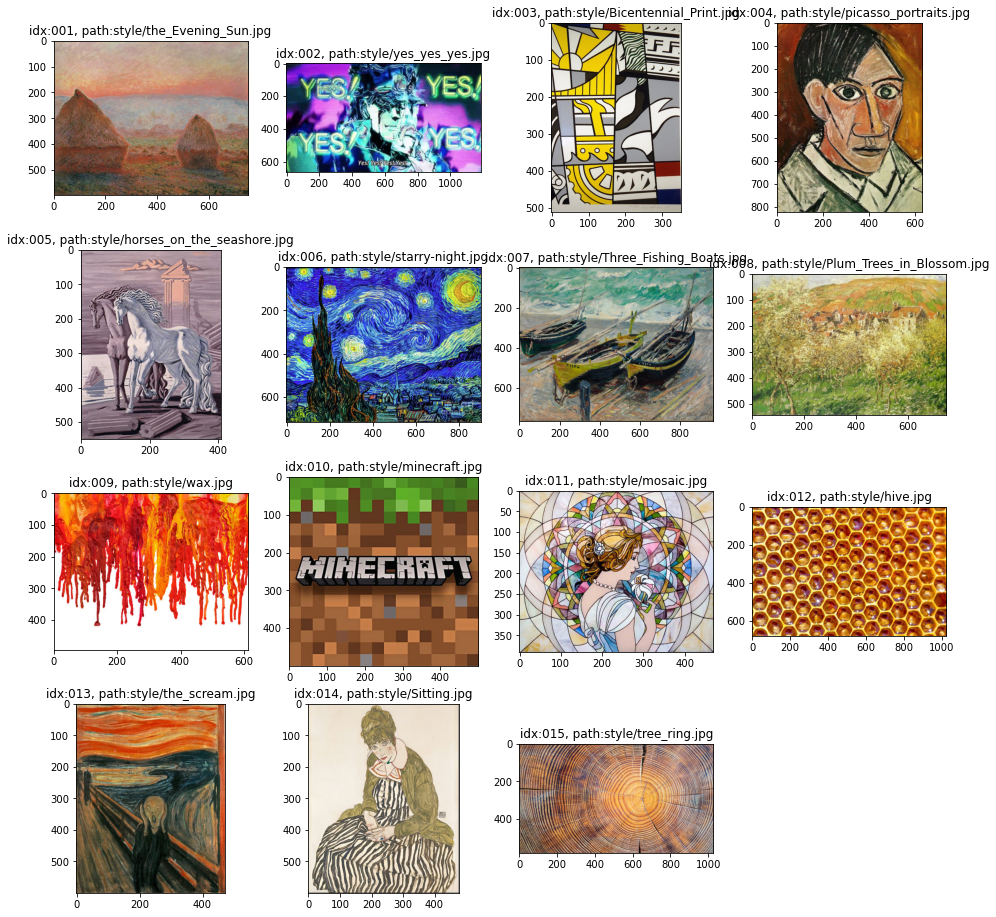

In [9]:
r,c = ((len(style_imgs)-1)//4+1),4
plt.figure(figsize=(r*4,c*4))
for idx, (img, path) in enumerate(zip(style_imgs, imgs_path), 1):
  plt.subplot(r,c,idx)
  plt.title(f"idx:{idx:03d}, path:{path}")
  plt.imshow(torch.permute(img, (1,2,0)).cpu().numpy().astype(np.uint8))

plt.show()

In [10]:
gram_style = defaultdict(list)
for style in style_imgs:
  for k,v in vgg(utils.normalize_batch(style.unsqueeze(0).to(device)), args.style_layers).items():
    gram_style[k].append(utils.gram_matrix(v))

gram_style = {layer_name : torch.cat(gram) for layer_name, gram in gram_style.items()}

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Before training

In [12]:
from datetime import datetime
folder = datetime.now().strftime("result_%Y-%m-%d-%H-%M")

from pathlib import Path
Path(folder).mkdir(parents=True, exist_ok=False)

if os.path.exists("result"):
  os.remove("result") 
os.symlink(folder, "result")


In [13]:
import json
with open(os.path.join(folder, "config.json"), "w") as f:
  json.dump(config,f)

In [14]:
doge_x = transforms.ToTensor()(
  utils.load_image(
    "doge.jpg",
#     "amber.jpg",
#     size=args.image_size
  )
)
doge_x = 255*doge_x.repeat(args.n_style, 1, 1, 1)
doge_x = doge_x.to(device)

test_style_idx = torch.arange(0,args.n_style,device=device)

# Go Training

epoch:0, iter:150, current_content_weight:1.0e+05
agg_content_loss = 629953.9070778146
agg_style_loss = 11767672.723509934


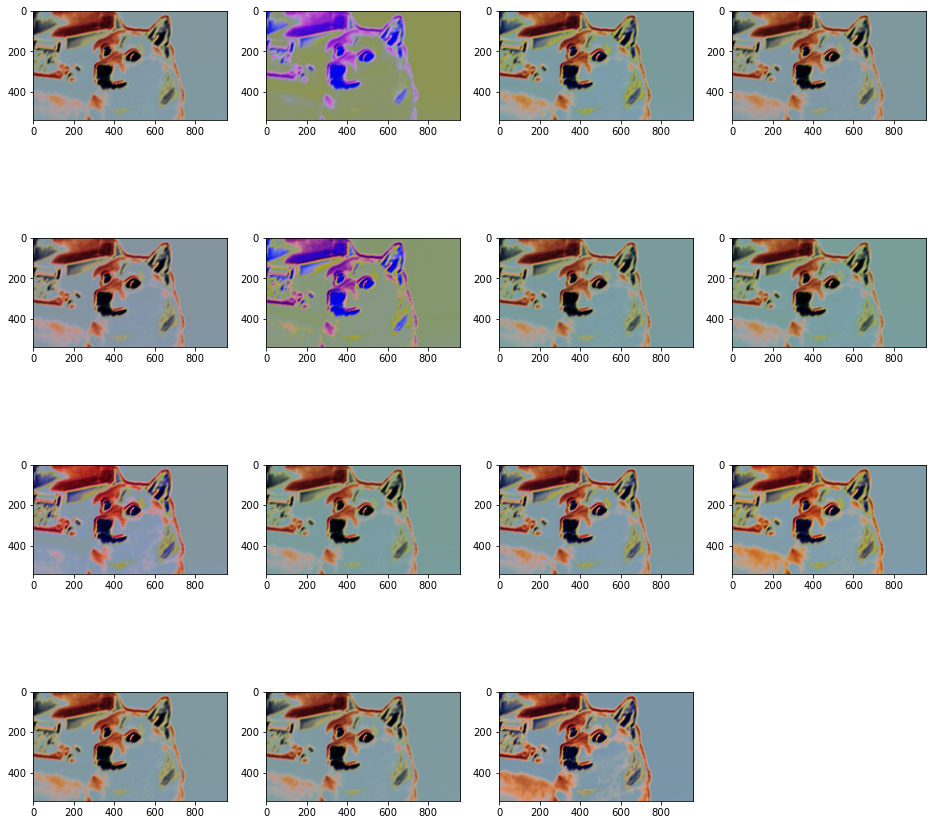

0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-97d54faab7d7>", line 18, in <module>
    y = transformer(x, rand_idx)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/jovyan/torch style transfer/A Learned Representation For Artistic Style/transformer_net.py", line 61, in forward
    y = 255*self.sigmoid(self.cin6(self.deconv3(y),style_idx))
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/jovyan/torch style transfer/A Learned Representation For Artistic Style/transformer_net.py", line 81, in forward
    noise_val = torch.normal(0, torch.ones_like(out)*self.noise_std)
KeyboardInterrupt

During handling of 

TypeError: object of type 'NoneType' has no len()

In [15]:
total_batches_pass = 0
for epoch in range(args.epochs):
  agg_content_loss = 0
  agg_style_loss = 0
  count = 0
  
  for batch_id, (x, _) in enumerate(train_loader):
    
    transformer.train()
    n_batch = len(x)
    count += n_batch
    optimizer.zero_grad()
    
    total_batches_pass+=1
    
    x = x.to(device)
    rand_idx = torch.randint(args.n_style, size=(n_batch,), device=device)
    y = transformer(x, rand_idx)
    
    y = utils.normalize_batch(y)
    x = utils.normalize_batch(x)
    
    features_y = vgg(y, args.feature_layers)
    features_x = vgg(x, args.content_layers) # do not compute style of this part
    
    content_loss = 0
    for layer_name in args.content_layers:
      content_loss += mse_loss(features_y[layer_name], features_x[layer_name])
    content_loss *= args.content_weight
    args.content_weight *= args.content_weight_decay
    args.content_weight = max(args.content_weight, args.content_weight_lower)
    
    style_loss = 0
    for layer_name, gram_source in gram_style.items():
      gm_y = utils.gram_matrix(features_y[layer_name])
      style_loss += mse_loss(gm_y, torch.index_select(gram_source, 0, rand_idx))
    style_loss *= args.style_weight
    
    total_loss = content_loss+style_loss
    total_loss.backward()
    optimizer.step()
    
    agg_content_loss += content_loss.item()
    agg_style_loss += style_loss.item()
    
    print(epoch, batch_id)
    if batch_id % 50 == 0:
      transformer.eval()
      with torch.no_grad():
        test_result = []
        for _test, _idx in zip(doge_x, test_style_idx):
          test_result.append(transformer(
            _test.unsqueeze(0),
            _idx.unsqueeze(0),
          ).detach()
          )
        test_result = torch.cat(test_result)/255
        test_result = torch.permute(test_result, (0,2,3,1)).cpu().detach().numpy()
        test_result = np.clip(test_result,0,1)

      r,c = ((len(style_imgs)-1)//4+1) , 4
      plt.figure(figsize=(r*4,c*4))
      for idx, img in enumerate(test_result,1):
        plt.subplot(r,c,idx)
        plt.imshow(img)
      
      display.clear_output(wait=True)
      print(f"epoch:{epoch}, iter:{batch_id}, current_content_weight:{args.content_weight:.1e}")
      print(f"agg_content_loss = {agg_content_loss/(batch_id+1)}\n"
            f"agg_style_loss = {agg_style_loss/(batch_id+1)}")
      plt.savefig(os.path.join(f"{folder}",f"e{epoch:03d}_b{batch_id:05d}.jpg"))
      plt.show()


    if total_batches_pass % args.save_every_n_batches == 0:
      transformer.eval()
      save_model_filename = f"total-batch{total_batches_pass}_epoch_{epoch}_batch_{batch_id}.pth"
      save_model_path = os.path.join(folder, save_model_filename)
      save_model_last_path = os.path.join(folder, "last.pth")

      torch.save(transformer.state_dict(), save_model_path)
      torch.save(transformer.state_dict(), save_model_last_path)